# Simple MAD

This notebook shows the simplest possible MAD: a two pixel image, where our models are L2-norm and L1-norm. It will not explain the basics of MAD Competition or how to use it. Instead, since we're dealing with a simple and low-dimensional example, we can plot the image in pixel space and draw out the model contours, which we can use to explicitly check whether we've found the correct results.

In [1]:
import plenoptic as po
import torch
import pyrtools as pt
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

Synthesizing model_1_min



Synthesizing model_1_max



Synthesizing model_2_min



Synthesizing model_2_max


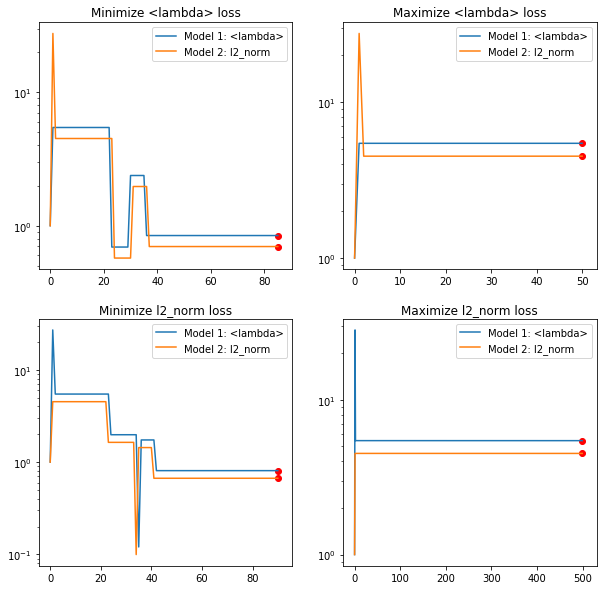

In [2]:
img = torch.tensor([.5, .5], dtype=torch.float32).reshape((1, 1, 1, 2))
mad = po.synth.MADCompetition(img, lambda x, y: torch.norm(x-y, 1), po.optim.l2_norm)
mad.synthesize_all(store_progress=True, max_iter=500, fix_step_n_iter=1, optimizer='GD',)

mad.plot_loss_all();

Woah -- that looks bad. What's going on? If we look at the loss in the first several iterations, we see it's bouncing around and the two losses are moving together, which isn't good.

If we think about our problem, we have two pixels, bounded between 0 and 1. The default learning rate is 1, which will be way too large in this case. Let's try reducing it and see if that helps.

Synthesizing model_1_min



Synthesizing model_1_max



Synthesizing model_2_min



Synthesizing model_2_max


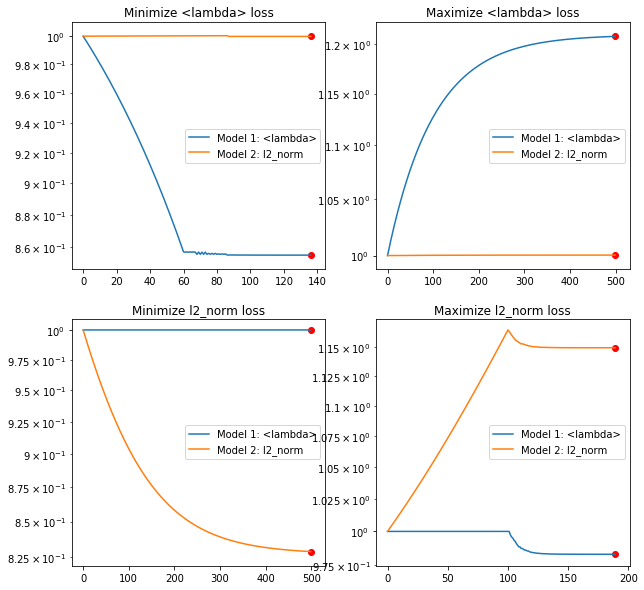

In [3]:
img = torch.tensor([.5, .5], dtype=torch.float32).reshape((1, 1, 1, 2))
mad = po.synth.MADCompetition(img, lambda x, y: torch.norm(x-y, 1), po.optim.l2_norm,)
mad.synthesize_all(store_progress=True, max_iter=500, fix_step_n_iter=1, optimizer='GD', learning_rate=.0001, )

mad.plot_loss_all();

That's better, but they're barely making any progress before they flatten out -- what's going on?

Since our images only have two pixels, we can easily plot them in pixel space: first pixel value on the x-axis, second on the y-axis. We can use this to visualize the points and how far they are from each other. We also know what the level curves look like for the $L_1$ and $L_2$ norms (a diamond and a circle centered on our target image, respectively), so we can add them as well.

In [4]:
l1 = po.to_numpy(torch.norm(mad.base_signal - mad.initial_image, 1))
l2 = po.to_numpy(torch.norm(mad.base_signal - mad.initial_image, 2))
tgt = po.to_numpy(mad.base_signal.squeeze())
init = po.to_numpy(mad.initial_image.squeeze())

def circle(origin, r, n=1000):
    theta = 2*np.pi/n*np.arange(0, n+1)
    return np.array([origin[1]+r*np.cos(theta), origin[0]+r*np.sin(theta)])
def diamond(origin, r, n=1000):
    theta = 2*np.pi/n*np.arange(0, n+1)
    rotation = np.pi/4
    square_correction = (np.abs(np.cos(theta-rotation)-np.sin(theta-rotation)) + np.abs(np.cos(theta-rotation)+np.sin(theta-rotation)))
    square_correction /= square_correction[0]
    r = r / square_correction
    return np.array([origin[1]+r*np.cos(theta), origin[0]+r*np.sin(theta)])
l2_level_set = circle(tgt, l2,)
l1_level_set = diamond(tgt, l1)

We can see in the following plot that it actually is doing the right thing, it's just very hard to separate these two metrics.

Generally, you're working with metrics/models where you can't make the following plot to double-check the performance of MAD. Unfortunately, you'll have to spend time playing with the various optimization parameters (don't forget `fix_iter_n_steps`!) in order to find what works best

You may have noticed that I'm using regular gradient descent in these -- it outperforms Adam in this instance (you can test by switching it yourself). In situations where the gradients are more complicated, that probably won't be the case, but it's worth checking a couple different optimizers to get a feel for how it works

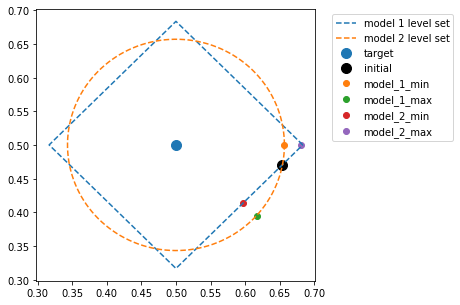

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(*tgt, label='target', s=100)
ax.scatter(*init, label='initial', c='k', s=100)
for k, v in mad.synthesized_signal_all.items():
    ax.scatter(*v.squeeze().detach(), label=k)
ax.plot(*l1_level_set, '--', label='model 1 level set')
ax.plot(*l2_level_set, '--', label='model 2 level set')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

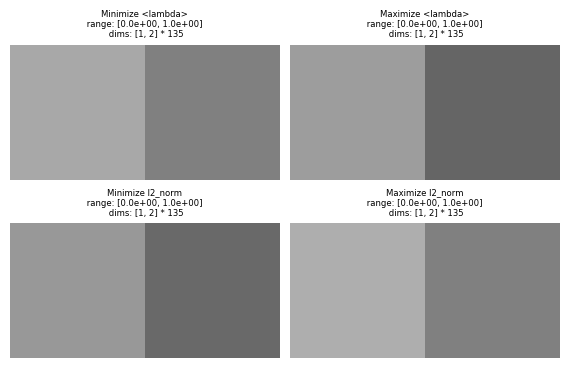

In [6]:
mad.plot_synthesized_image_all(imshow_zoom=135, vrange=(0, 1));